In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..')
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [4]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data()
fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
                               negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,...,ast_ngram_n_7_0,ast_ngram_n_7_1,ast_ngram_n_7_2,ast_ngram_n_7_3,ast_ngram_n_7_4,ast_ngram_n_7_5,ast_ngram_n_7_6,ast_ngram_n_7_7,ast_ngram_n_7_8,ast_ngram_n_7_9
0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1,1,1,1.00,0,...,0,0,1,1,0,0,0,0,0,0
1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1,1,1,1.00,0,...,1,1,0,0,1,1,0,0,1,1
2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1,1,1,0.00,0,...,0,0,0,0,0,0,0,0,0,0
3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1,1,1,0.00,0,...,1,1,1,1,1,1,0,0,1,1
4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1,1,1,0.25,0,...,1,1,1,1,1,1,1,1,1,1


In [5]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df

model_path = '../models/cv_fitness_model_2023_02_15.pkl.gz'
data_df = fitness_df

with gzip.open(model_path, 'rb') as f:
    cv_energy_model = pickle.load(f)

feature_columns = [c for c in data_df.columns if c not in NON_FEATURE_COLUMNS]


## Histogram the weights to get a sense of what we're dealing with

Weights mean: 0.1042, std: 0.4409, bias: 1.8432


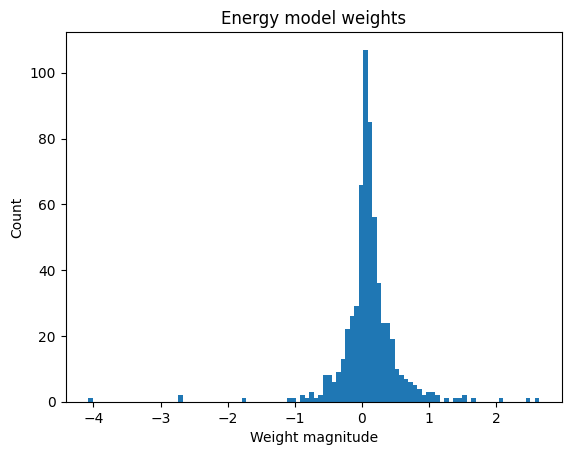

In [6]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=100)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [7]:
for magnitude in (0.01, 0.05, 0.1, 0.5):
    n = torch.sum(torch.abs(weights) < magnitude)
    print(f'Number of weights with magnitude < {magnitude}: {n} ({n / len(weights) * 100:.2f}%)')

Number of weights with magnitude < 0.01: 21 (3.43%)
Number of weights with magnitude < 0.05: 113 (18.46%)
Number of weights with magnitude < 0.1: 214 (34.97%)
Number of weights with magnitude < 0.5: 529 (86.44%)


## Print the top K features most and least predictive of real games

In [8]:
K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games:')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games:')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games:
1. ast_ngram_score (-4.0788)
2. all_variables_used (-2.6793)
3. variable_not_repeated (-2.6729)
4. all_preferences_used (-1.7698)
5. no_two_number_operations (-1.1218)
6. ast_ngram_n_6_7 (-1.0344)
7. on_arg_types_furniture_any_object_constraints (-0.8780)
8. no_adjacent_same_modal (-0.8707)
9. ast_ngram_n_6_1 (-0.8093)
10. no_nested_logicals (-0.7770)
11. on_arg_types_furniture_large_objects_setup (-0.7659)
12. compositionality_structure_5 (-0.7363)
13. ast_ngram_n_5_1 (-0.6741)
14. on_arg_types_furniture_large_objects_constraints (-0.6416)
15. length_of_then_modals_4 (-0.6389)
16. in_arg_types_receptacles_balls_constraints (-0.5643)
17. touch_arg_types_agent_balls_constraints (-0.5608)
18. in_motion_arg_types_small_objects_constraints (-0.5502)
19. distance_arg_types_room_features_receptacles_setup (-0.5400)
20. on_arg_types_furniture_furniture_constraints (-0.5345)
### Features with largest positive weights (most predictive of fake games:
1. pref_forall_pref_forall_correct_types_incorrect (2.6386)
2. redundant_expression_found (2.4549)
3. pref_forall_pref_forall_correct_arity_incorrect (2.0695)
4. ast_ngram_n_2_5 (1.6692)
5. ast_ngram_n_2_4 (1.5218)
6. ast_ngram_n_3_0 (1.5204)
7. in_motion_arg_types_receptacles_constraints (1.4647)
8. agent_holds_arg_types_room_features_constraints (1.4070)
9. on_arg_types_other_constraints (1.2592)
10. ast_ngram_n_2_0 (1.1450)
11. in_motion_arg_types_room_features_constraints (1.0985)
12. touch_arg_types_other_constraints (1.0763)
13. distance_arg_types_other_setup (1.0698)
14. no_identical_logical_children (1.0650)
15. agent_holds_arg_types_agent_constraints (1.0185)
16. agent_holds_arg_types_receptacles_constraints (1.0130)
17. max_number_variables_types_quantified_variables_2 (0.9737)
18. max_depth_terminal_3 (0.9099)
19. agent_holds_arg_types_furniture_constraints (0.9042)
20. adjacent_arg_types_other_constraints (0.8742)

In [14]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if 'max_number_variables_types_quantified' in c]

[('max_number_variables_types_quantified_types_1', tensor(0.4498)),
 ('max_number_variables_types_quantified_types_2', tensor(0.5280)),
 ('max_number_variables_types_quantified_types_3', tensor(0.6662)),
 ('max_number_variables_types_quantified_types_4', tensor(0.1977)),
 ('max_number_variables_types_quantified_types_5', tensor(0.0814)),
 ('max_number_variables_types_quantified_types_6', tensor(0.0857)),
 ('max_number_variables_types_quantified_types_7', tensor(-0.1307)),
 ('max_number_variables_types_quantified_types_8', tensor(0.0880)),
 ('max_number_variables_types_quantified_variables_1', tensor(0.4726)),
 ('max_number_variables_types_quantified_variables_2', tensor(0.9737)),
 ('max_number_variables_types_quantified_variables_3', tensor(0.1327)),
 ('max_number_variables_types_quantified_variables_4', tensor(-0.0152)),
 ('max_number_variables_types_quantified_variables_5', tensor(0.0373)),
 ('max_number_variables_types_quantified_variables_6', tensor(0.1291)),
 ('max_number_variable

In [15]:
data_df.groupby('real')[[c for c in feature_columns if 'max_number_variables_types_quantified' in c]].mean()

,max_number_variables_types_quantified_types_1,max_number_variables_types_quantified_types_2,max_number_variables_types_quantified_types_3,max_number_variables_types_quantified_types_4,max_number_variables_types_quantified_types_5,max_number_variables_types_quantified_types_6,max_number_variables_types_quantified_types_7,max_number_variables_types_quantified_types_8,max_number_variables_types_quantified_variables_1,max_number_variables_types_quantified_variables_2,max_number_variables_types_quantified_variables_3,max_number_variables_types_quantified_variables_4,max_number_variables_types_quantified_variables_5,max_number_variables_types_quantified_variables_6,max_number_variables_types_quantified_variables_7,max_number_variables_types_quantified_variables_8
real,,,,,,,,,,,,,,,,
0,0.628827,0.194595,0.121413,0.023278,0.010682,0.0,0.021205,0.0,0.766103,0.153858,0.004066,0.022321,0.010842,0.032047,0.0,0.010762
1,0.653061,0.183673,0.112245,0.020408,0.010204,0.0,0.020408,0.0,0.785714,0.142857,0.000000,0.020408,0.010204,0.030612,0.0,0.010204


## Plot a histogram of the values for each of the and bottom K features

In [16]:
def plot_value_histograms(df: pd.DataFrame, weights: torch.Tensor, k: int = 10,
    largest: bool = True, bins: int = 100, histogram_log_y: bool = True, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    columns = [c for c in df.columns if c not in NON_FEATURE_COLUMNS]
    top_k = torch.topk(weights, k, largest=largest)

    for i in range(k):
        feature_index = top_k.indices[i]
        ax = axes[i // layout[1]][i % layout[1]]

        real_values = df[df.real == 1][feature_columns[feature_index]].to_numpy()
        synthetic_values = df[df.real == 0][feature_columns[feature_index]].to_numpy()

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([real_values, synthetic_values], label=['Real games', 'Regrown games'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Feature value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title_feature = f'#{i + 1}: {columns[feature_index]}'
        title_weight = f'(weight: {top_k.values[i]:.4f})'
        if len(title_feature) > title_split_threshold:
            title_split_index = title_feature.find('_', title_split_threshold) + 1
            if title_split_index == 0:
                title_split_index = len(title_feature)
            title = f'{title_feature[:title_split_index]}\n{title_feature[title_split_index:]} {title_weight}'
        else:
            title = f'{title_feature}\n{title_weight}'

        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()

        

## For the 20 features with the largest negative weights, that is, most predictive of real games

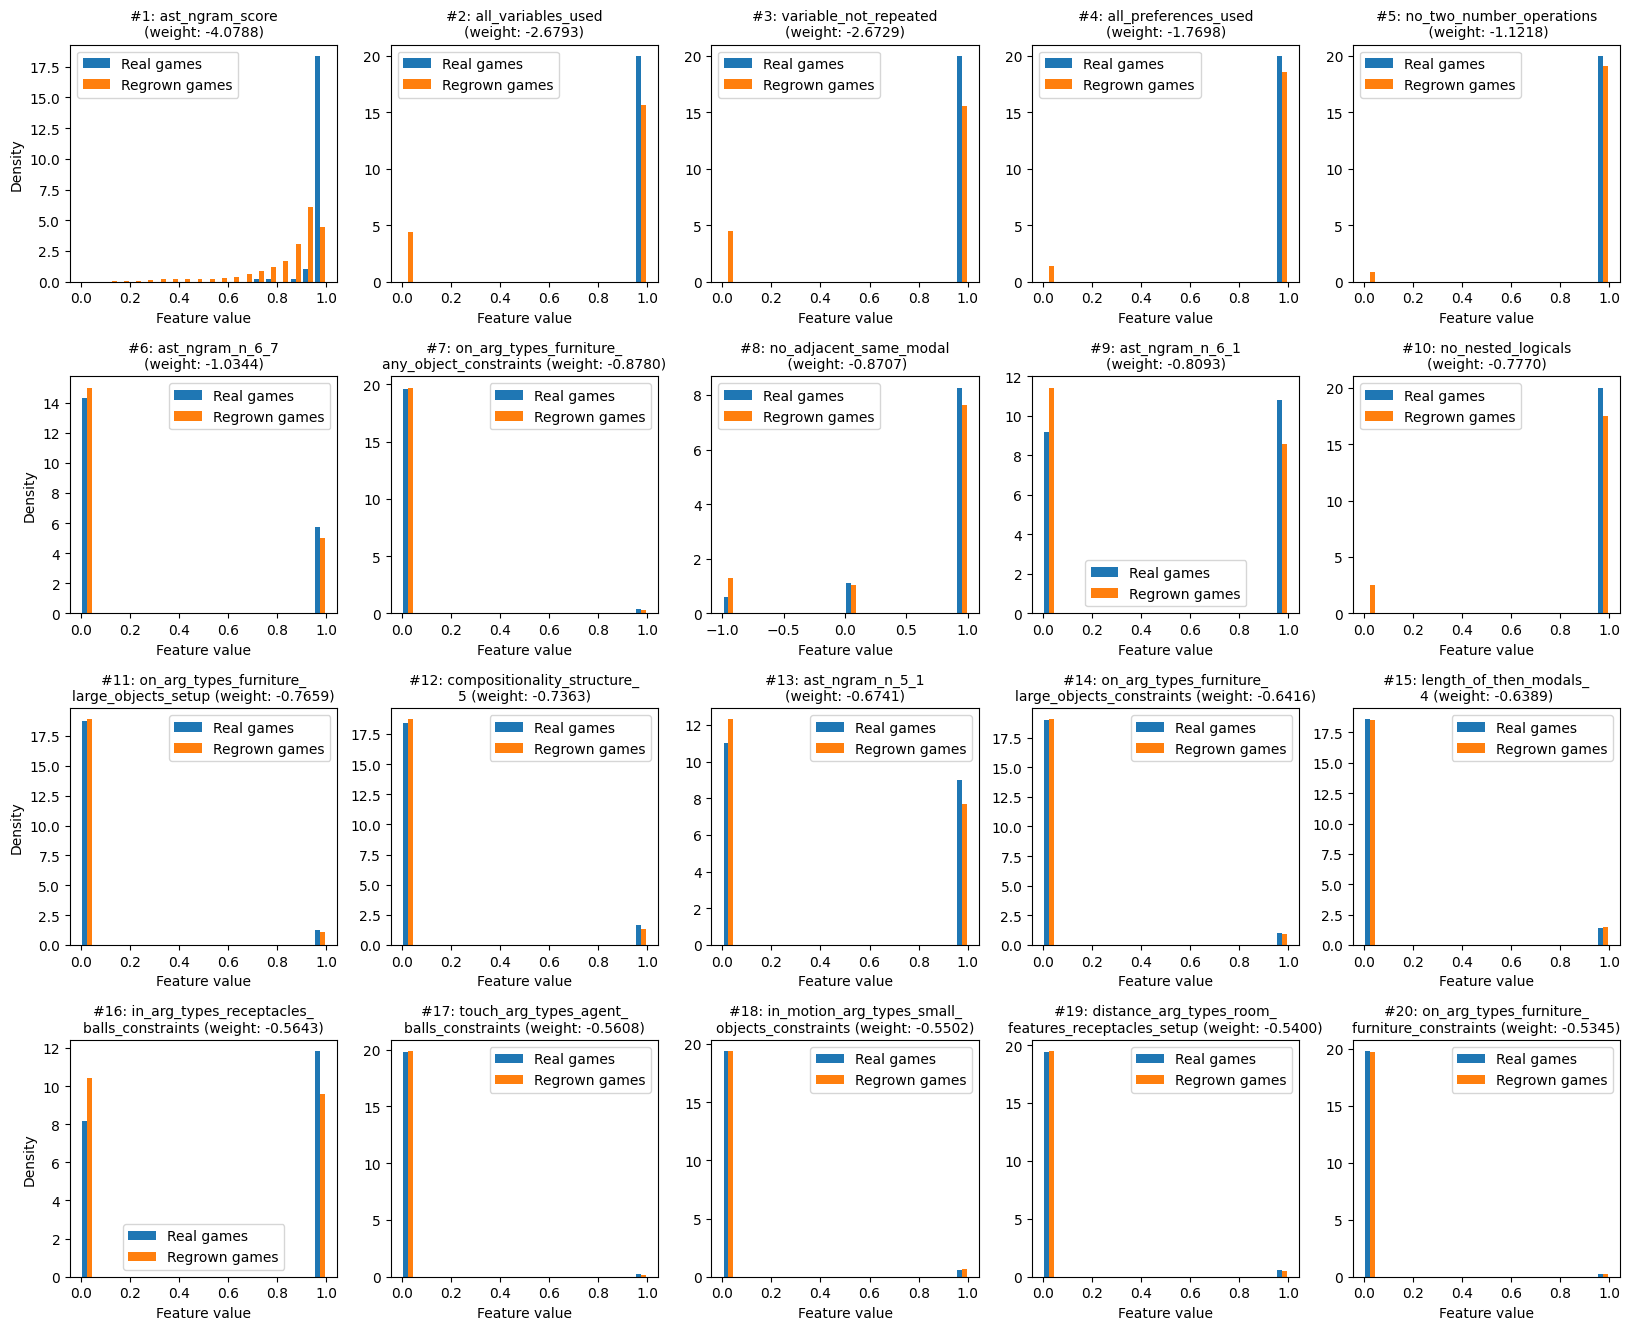

In [17]:
k = 20
plot_value_histograms(data_df, weights, k=k, largest=False, bins=20, histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## For the 20 features with largest weights, that is, most predictive of a fake game

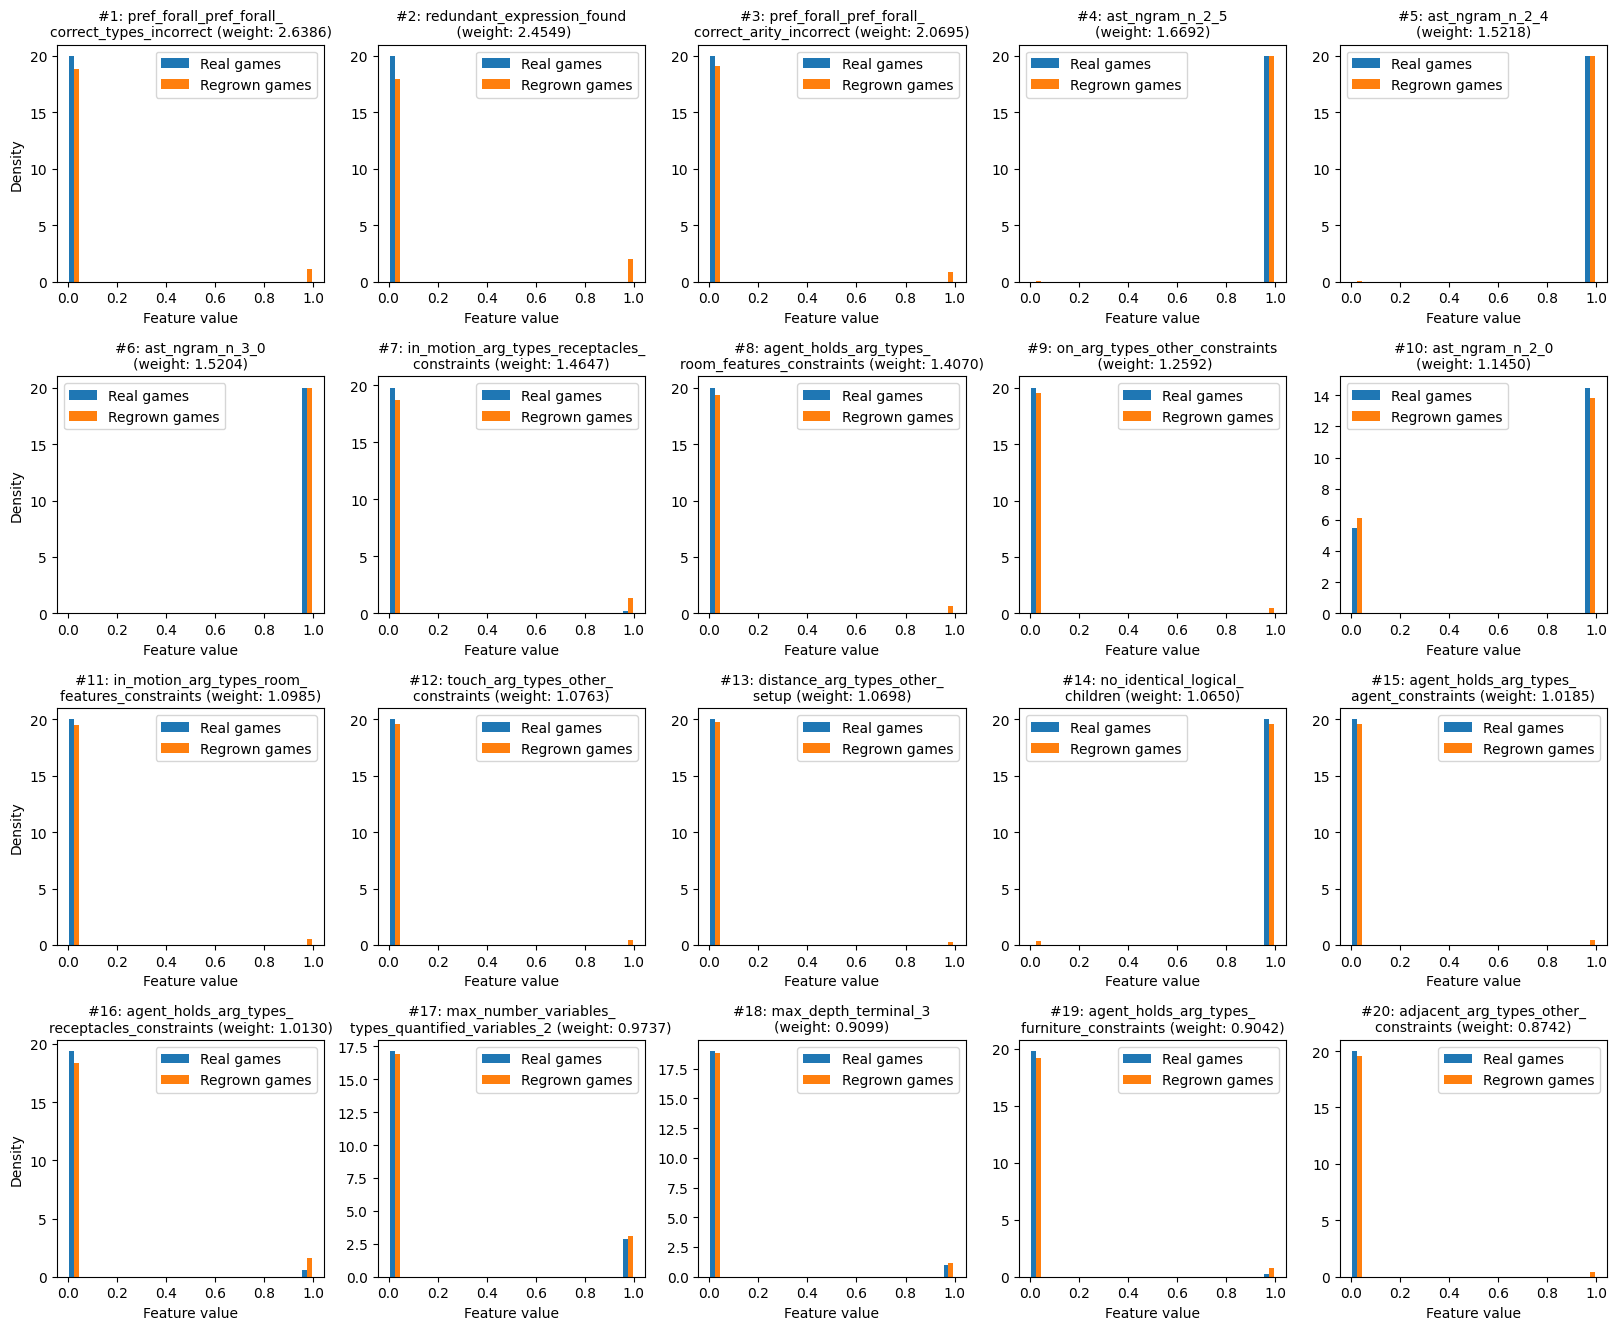

In [18]:
plot_value_histograms(data_df, weights, k=k, largest=True, bins=20,  histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## Visualizing some top negatives

In [19]:
feature_columns = [c for c in data_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [20]:
real_game_scores = full_tensor_scores[:, 0]
print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}')

Real game scores: 0.6147 ± 0.4764


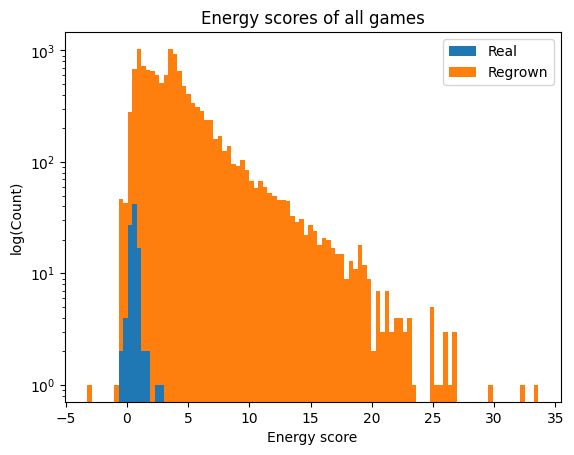

In [21]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

In [22]:
negatives = full_tensor[:, 1:, :]
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
negatives_scores = cv_energy_model.transform(negatives).detach()

In [23]:
positive_scores = full_tensor_scores[:, 0]
score_diffs = negatives_scores - positive_scores.unsqueeze(1)

In [24]:
torch.topk(score_diffs.ravel(), 10, largest=False)

torch.return_types.topk(
values=tensor([-3.6235, -1.0466, -0.9208, -0.7063, -0.6825, -0.6598, -0.6356, -0.6057,
        -0.5600, -0.5466]),
indices=tensor([ 6435,   690, 11100,  7809,  7403,  8441, 10213,   641,  2775, 11775]))

In [25]:
N_NEGATIVES = 10
for index in torch.topk(score_diffs.ravel(), N_NEGATIVES, largest=False).indices:
    utils.evaluate_energy_contributions(cv_energy_model, full_tensor, index, 
        feature_columns, full_tensor, real_game_texts, regrown_game_texts, display_features_diff=False)
    
    display(Markdown('---'))

Original game index: 50 | Negative game row: 50 | Negative game col: 35


### Energy of real game: 0.371 | Energy of regrown game: -3.252 | Difference: -3.623

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                          | Features decreasing energy (= more real)                                      |
|-----------------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| ast_ngram_n_6_1: **0.809** = (1.000 => 0.000) * -0.809                            | ast_ngram_n_2_5: **-1.669** = (1.000 => 0.000) * 1.669                        |
| ast_ngram_n_5_1: **0.674** = (1.000 => 0.000) * -0.674                            | ast_ngram_n_2_4: **-1.522** = (1.000 => 0.000) * 1.522                        |
| ast_ngram_score: **0.657** = (0.980 => 0.818) * -4.079                            | ast_ngram_n_3_0: **-1.520** = (1.000 => 0.000) * 1.520                        |
| mean_depth_constraints_1: **0.598** = (0.000 => 1.000) * 0.598                    | ast_ngram_n_2_1: **-0.872** = (1.000 => 0.000) * 0.872                        |
| in_arg_types_receptacles_balls_constraints: **0.564** = (1.000 => 0.000) * -0.564 | max_quantification_count_constraints_2: **-0.747** = (1.000 => 0.000) * 0.747 |
| max_quantification_count_constraints_1: **0.538** = (0.000 => 1.000) * 0.538      | max_depth_constraints_2: **-0.701** = (1.000 => 0.000) * 0.701                |
| node_count_constraints_0: **0.529** = (0.000 => 1.000) * 0.529                    | ast_ngram_n_2_3: **-0.691** = (1.000 => 0.000) * 0.691                        |
| ast_ngram_n_6_6: **0.479** = (1.000 => 0.000) * -0.479                            | length_of_then_modals_3: **-0.629** = (1.000 => 0.000) * 0.629                |
| ast_ngram_n_4_5: **0.470** = (1.000 => 0.000) * -0.470                            | in_motion_arg_types_balls_constraints: **-0.533** = (1.000 => 0.000) * 0.533  |
| ast_ngram_n_4_0: **0.449** = (1.000 => 0.000) * -0.449                            | ast_ngram_n_5_8: **-0.477** = (1.000 => 0.000) * 0.477                        |

### Game Diffs

n,1,(define (game 602a1735bf92e79a5e7cb632-59) (:domain many-objects-room-v1),n,1,(define (game 602a1735bf92e79a5e7cb632-59-35-nd6-rd15) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
,6,(< (distance ?h door) 1),,6,(< (distance ?h door) 1)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)
,11,(:constraints,,11,(:constraints


---

Original game index: 5 | Negative game row: 5 | Negative game col: 50


### Energy of real game: 0.847 | Energy of regrown game: -0.199 | Difference: -1.047

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)               | Features decreasing energy (= more real)                            |
|--------------------------------------------------------|---------------------------------------------------------------------|
| ast_ngram_score: **0.171** = (0.982 => 0.940) * -4.079 | ast_ngram_n_7_1: **-0.291** = (1.000 => 0.000) * 0.291              |
| ast_ngram_n_7_0: **0.055** = (1.000 => 0.000) * -0.055 | ast_ngram_n_5_5: **-0.283** = (1.000 => 0.000) * 0.283              |
|                                                        | ast_ngram_n_6_2: **-0.240** = (1.000 => 0.000) * 0.240              |
|                                                        | ast_ngram_n_4_8: **-0.163** = (1.000 => 0.000) * 0.163              |
|                                                        | ast_ngram_n_6_3: **-0.113** = (1.000 => 0.000) * 0.113              |
|                                                        | compositionality_structure_0: **-0.105** = (1.000 => 0.000) * 0.105 |
|                                                        | ast_ngram_n_5_6: **-0.078** = (1.000 => 0.000) * 0.078              |

### Game Diffs

n,1,(define (game 615b40bb6cdb0f1f6f291f45-8) (:domain few-objects-room-v1),n,1,(define (game 615b40bb6cdb0f1f6f291f45-8-50-nd13-rd4) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?c - curved_wooden_ramp),,4,(exists (?c - curved_wooden_ramp)
,5,(game-conserved,,5,(game-conserved
,6,(on floor ?c),,6,(on floor ?c)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)
,11,(:constraints,,11,(:constraints


---

Original game index: 86 | Negative game row: 86 | Negative game col: 92


### Energy of real game: 2.498 | Energy of regrown game: 1.578 | Difference: -0.921

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                          | Features decreasing energy (= more real)                                                |
|-----------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| ast_ngram_n_6_7: **1.034** = (1.000 => 0.000) * -1.034                            | ast_ngram_n_2_0: **-1.145** = (1.000 => 0.000) * 1.145                                  |
| ast_ngram_score: **0.996** = (0.972 => 0.727) * -4.079                            | ast_ngram_n_2_1: **-0.872** = (1.000 => 0.000) * 0.872                                  |
| in_arg_types_receptacles_balls_constraints: **0.564** = (1.000 => 0.000) * -0.564 | agent_holds_arg_types_balls_constraints: **-0.840** = (1.000 => 0.000) * 0.840          |
| ast_ngram_n_3_1: **0.530** = (1.000 => 0.000) * -0.530                            | in_motion_arg_types_balls_constraints: **-0.533** = (1.000 => 0.000) * 0.533            |
| ast_ngram_n_5_4: **0.243** = (1.000 => 0.000) * -0.243                            | agent_holds_arg_types_any_object_constraints: **-0.303** = (0.000 => 1.000) * -0.303    |
|                                                                                   | ast_ngram_n_4_2: **-0.227** = (1.000 => 0.000) * 0.227                                  |
|                                                                                   | in_arg_types_receptacles_any_object_constraints: **-0.168** = (0.000 => 1.000) * -0.168 |
|                                                                                   | in_motion_arg_types_any_object_constraints: **-0.145** = (0.000 => 1.000) * -0.145      |
|                                                                                   | ast_ngram_n_3_9: **-0.055** = (1.000 => 0.000) * 0.055                                  |

### Game Diffs

n,1,(define (game 6106ac34408681f3b0d07396-104) (:domain few-objects-room-v1),n,1,(define (game 6106ac34408681f3b0d07396-104-92-nd8-rd1) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
,6,(and,,6,(and
,7,(equal_x_position ?h east_sliding_door),,7,(equal_x_position ?h east_sliding_door)
,8,),,8,)
,9,),,9,)
,10,),,10,)
,11,),,11,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 1


### Energy of real game: 0.844 | Energy of regrown game: 0.138 | Difference: -0.706

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                               | Features decreasing energy (= more real)                |
|----------------------------------------------------------------------------------------|---------------------------------------------------------|
| touch_arg_types_balls_large_objects_constraints: **0.307** = (1.000 => 0.000) * -0.307 | ast_ngram_n_5_1: **-0.674** = (0.000 => 1.000) * -0.674 |
| compositionality_structure_7: **0.121** = (1.000 => 0.000) * -0.121                    | ast_ngram_n_4_5: **-0.470** = (0.000 => 1.000) * -0.470 |
| ast_ngram_n_6_3: **0.113** = (0.000 => 1.000) * 0.113                                  | ast_ngram_n_4_6: **-0.294** = (0.000 => 1.000) * -0.294 |
| ast_ngram_score: **0.112** = (0.992 => 0.964) * -4.079                                 |                                                         |
| ast_ngram_n_5_6: **0.078** = (0.000 => 1.000) * 0.078                                  |                                                         |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-1-nd9-rd4) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)
,11,),,11,)


---

Original game index: 57 | Negative game row: 57 | Negative game col: 107


### Energy of real game: 0.828 | Energy of regrown game: 0.146 | Difference: -0.682

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)               | Features decreasing energy (= more real)                            |
|--------------------------------------------------------|---------------------------------------------------------------------|
| ast_ngram_n_7_5: **0.295** = (1.000 => 0.000) * -0.295 | ast_ngram_n_7_9: **-0.308** = (1.000 => 0.000) * 0.308              |
| ast_ngram_n_6_8: **0.199** = (1.000 => 0.000) * -0.199 | ast_ngram_n_7_1: **-0.291** = (1.000 => 0.000) * 0.291              |
| ast_ngram_n_7_8: **0.149** = (1.000 => 0.000) * -0.149 | ast_ngram_n_5_5: **-0.283** = (1.000 => 0.000) * 0.283              |
| ast_ngram_n_2_9: **0.136** = (1.000 => 0.000) * -0.136 | ast_ngram_n_6_2: **-0.240** = (1.000 => 0.000) * 0.240              |
| ast_ngram_score: **0.065** = (0.980 => 0.964) * -4.079 | ast_ngram_n_4_8: **-0.163** = (1.000 => 0.000) * 0.163              |
| ast_ngram_n_7_0: **0.055** = (1.000 => 0.000) * -0.055 | ast_ngram_n_6_3: **-0.113** = (1.000 => 0.000) * 0.113              |
|                                                        | compositionality_structure_0: **-0.105** = (1.000 => 0.000) * 0.105 |
|                                                        | ast_ngram_n_5_6: **-0.078** = (1.000 => 0.000) * 0.078              |

### Game Diffs

n,1,(define (game 60feca537ed1de34c8ddbbab-67) (:domain medium-objects-room-v1),n,1,(define (game 60feca537ed1de34c8ddbbab-67-107-nd9-rd10) (:domain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?b1 ?b2 ?b3 ?b4 ?b5 ?b6 ?b7 ?b8 ?b9 ?b10 - (either tall_cylindrical_block bridge_block,,4,(exists (?b1 ?b2 ?b3 ?b4 ?b5 ?b6 ?b7 ?b8 ?b9 ?b10 - (either tall_cylindrical_block bridge_block
,>,flat_block cube_block cylindrical_block)),,>,flat_block cube_block cylindrical_block))
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(= (distance desk ?b1) (distance desk ?b2) (distance desk ?b3) (distance desk ?b4)),,7,(= (distance desk ?b1) (distance desk ?b2) (distance desk ?b3) (distance desk ?b4))
,8,(= (distance desk ?b5) (distance desk ?b6) (distance desk ?b7)),,8,(= (distance desk ?b5) (distance desk ?b6) (distance desk ?b7))
,9,(= (distance desk ?b8) (distance desk ?b9)),,9,(= (distance desk ?b8) (distance desk ?b9))
,10,(< (distance desk ?b10) 2),,10,(< (distance desk ?b10) 2)


---

Original game index: 65 | Negative game row: 65 | Negative game col: 121


### Energy of real game: 0.990 | Energy of regrown game: 0.331 | Difference: -0.660

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                       | Features decreasing energy (= more real)                             |
|--------------------------------------------------------------------------------|----------------------------------------------------------------------|
| ast_ngram_n_4_9: **0.260** = (0.000 => 1.000) * 0.260                          | ast_ngram_n_6_1: **-0.809** = (0.000 => 1.000) * -0.809              |
| in_arg_types_furniture_balls_constraints: **0.225** = (0.000 => 1.000) * 0.225 | ast_ngram_n_5_3: **-0.322** = (0.000 => 1.000) * -0.322              |
| ast_ngram_score: **0.093** = (0.979 => 0.956) * -4.079                         | compositionality_structure_10: **-0.107** = (1.000 => 0.000) * 0.107 |

### Game Diffs

n,1,(define (game 5d0ba121619661001a7f4fe6-76) (:domain few-objects-room-v1),n,1,(define (game 5d0ba121619661001a7f4fe6-76-121-nd10-rd3) (:domain few-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(forall (?c - (either pink yellow)),,4,(forall (?c - (either pink yellow))
,5,(and,,5,(and
,6,(preference blockToBinFromRug,,6,(preference blockToBinFromRug
,7,(exists (?b - cube_block ?h - hexagonal_bin),,7,(exists (?b - cube_block ?h - hexagonal_bin)
,8,(then,,8,(then
,9,(once (and (agent_holds ?b) (rug_color_under agent ?c) ) ),,9,(once (and (agent_holds ?b) (rug_color_under agent ?c) ) )
,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) ),,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) )
,11,(once (and (not (in_motion ?b) ) (or (in ?h ?b) (exists (?bl - building) (and (in ?bl,,11,(once (and (not (in_motion ?b) ) (or (in ?h ?b) (exists (?bl - building) (and (in ?bl


---

Original game index: 79 | Negative game row: 79 | Negative game col: 101


### Energy of real game: 0.407 | Energy of regrown game: -0.229 | Difference: -0.636

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                  | Features decreasing energy (= more real)                |
|-----------------------------------------------------------|---------------------------------------------------------|
| no_nested_logicals: **0.777** = (1.000 => 0.000) * -0.777 | ast_ngram_n_5_1: **-0.674** = (0.000 => 1.000) * -0.674 |
| ast_ngram_n_3_8: **0.244** = (0.000 => 1.000) * 0.244     | ast_ngram_n_4_5: **-0.470** = (0.000 => 1.000) * -0.470 |
| ast_ngram_score: **0.241** = (0.973 => 0.914) * -4.079    | ast_ngram_n_6_0: **-0.425** = (0.000 => 1.000) * -0.425 |
| ast_ngram_n_4_7: **0.133** = (0.000 => 1.000) * 0.133     | ast_ngram_n_4_6: **-0.294** = (0.000 => 1.000) * -0.294 |
|                                                           | ast_ngram_n_5_2: **-0.166** = (0.000 => 1.000) * -0.166 |

### Game Diffs

n,1,(define (game 5cdad620eae6f70019d4e950-94) (:domain many-objects-room-v1),n,1,(define (game 5cdad620eae6f70019d4e950-94-101-nd12-rd4) (:domain many-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(forall (?b - (either dodgeball golfball)),,4,(forall (?b - (either dodgeball golfball))
,5,(and,,5,(and
,6,(preference ballThrownFromDoor,,6,(preference ballThrownFromDoor
,7,(exists (?h - hexagonal_bin),,7,(exists (?h - hexagonal_bin)
,8,(then,,8,(then
,9,(once (and (agent_holds ?b) (adjacent door agent) ) ),,9,(once (and (agent_holds ?b) (adjacent door agent) ) )
,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) ),,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) )
,11,(once (and (not (in_motion ?b) ) (in ?h ?b) ) ),,11,(once (and (not (in_motion ?b) ) (in ?h ?b) ) )


---

Original game index: 5 | Negative game row: 5 | Negative game col: 1


### Energy of real game: 0.847 | Energy of regrown game: 0.242 | Difference: -0.606

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                             | Features decreasing energy (= more real)               |
|--------------------------------------------------------------------------------------|--------------------------------------------------------|
| agent_holds_arg_types_orientations_constraints: **0.192** = (0.000 => 1.000) * 0.192 | ast_ngram_n_7_1: **-0.291** = (1.000 => 0.000) * 0.291 |
| ast_ngram_score: **0.152** = (0.982 => 0.944) * -4.079                               | ast_ngram_n_5_5: **-0.283** = (1.000 => 0.000) * 0.283 |
| ast_ngram_n_7_0: **0.055** = (1.000 => 0.000) * -0.055                               | ast_ngram_n_6_2: **-0.240** = (1.000 => 0.000) * 0.240 |
|                                                                                      | ast_ngram_n_6_3: **-0.113** = (1.000 => 0.000) * 0.113 |
|                                                                                      | ast_ngram_n_5_6: **-0.078** = (1.000 => 0.000) * 0.078 |

### Game Diffs

n,1,(define (game 615b40bb6cdb0f1f6f291f45-8) (:domain few-objects-room-v1),n,1,(define (game 615b40bb6cdb0f1f6f291f45-8-1-nd15-rd2) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?c - curved_wooden_ramp),,4,(exists (?c - curved_wooden_ramp)
,5,(game-conserved,,5,(game-conserved
,6,(on floor ?c),,6,(on floor ?c)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)
,11,(:constraints,,11,(:constraints


---

Original game index: 21 | Negative game row: 21 | Negative game col: 87


### Energy of real game: 0.727 | Energy of regrown game: 0.167 | Difference: -0.560

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                  | Features decreasing energy (= more real)                                              |
|-----------------------------------------------------------|---------------------------------------------------------------------------------------|
| ast_ngram_score: **0.172** = (0.917 => 0.875) * -4.079    | max_number_variables_types_quantified_types_3: **-0.666** = (1.000 => 0.000) * 0.666  |
| setup_objects_used: **0.064** = (1.000 => 0.800) * -0.322 | max_number_variables_types_quantified_types_7: **-0.131** = (0.000 => 1.000) * -0.131 |

### Game Diffs

n,1,(define (game 606e4eb2a56685e5593304cd-27) (:domain few-objects-room-v1),n,1,(define (game 606e4eb2a56685e5593304cd-27-87-nd9-rd2) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(forall (?d - (either dodgeball cube_block)),,4,(forall (?d - (either dodgeball cube_block))
,5,(game-optional,,5,(game-optional
,6,(not,,6,(not
,7,(exists (?s - shelf),,7,(exists (?s - shelf)
,8,(on ?s ?d),,8,(on ?s ?d)
,9,),,9,)
,10,),,10,)
,11,),,11,)


---

Original game index: 91 | Negative game row: 91 | Negative game col: 127


### Energy of real game: 2.953 | Energy of regrown game: 2.406 | Difference: -0.547

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                    | Features decreasing energy (= more real)                     |
|-------------------------------------------------------------|--------------------------------------------------------------|
| mean_depth_terminal_3: **0.220** = (0.000 => 1.000) * 0.220 | mean_depth_terminal_4: **-0.773** = (1.000 => 0.000) * 0.773 |
| ast_ngram_score: **0.007** = (0.769 => 0.767) * -4.079      |                                                              |

### Game Diffs

n,1,(define (game 6123dcdd95e4f8afd71928a3-110) (:domain few-objects-room-v1),n,1,(define (game 6123dcdd95e4f8afd71928a3-110-127-nd6-rd7) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(forall (?c - chair),,4,(forall (?c - chair)
,5,(game-conserved,,5,(game-conserved
,6,(equal_x_position ?c door),,6,(equal_x_position ?c door)
,7,),,7,)
,8,),,8,)
,9,(exists (?h - hexagonal_bin),,9,(exists (?h - hexagonal_bin)
,10,(game-conserved,,10,(game-conserved
,11,(and,,11,(and


---

In [32]:
threshold = 0.98
gb = data_df.groupby('real').mean(numeric_only=True)
for c in gb.columns:
    if (gb[c] > threshold).all():
        print(f'Feature {c} is (almost) always 1: {gb[c].to_dict()}')

Feature no_identical_logical_children is (almost) always 1: {0: 0.9817442602040817, 1: 1.0}
Feature ast_ngram_n_2_4 is (almost) always 1: {0: 0.9989636479591837, 1: 1.0}
Feature ast_ngram_n_2_5 is (almost) always 1: {0: 0.9989636479591837, 1: 1.0}
Feature ast_ngram_n_3_0 is (almost) always 1: {0: 0.9989636479591837, 1: 1.0}


In [59]:
data_df.groupby('real')[[c for c in data_df.columns if 'quantification' in c]].mean(numeric_only=True)

,max_quantification_count_setup_0,max_quantification_count_setup_1,max_quantification_count_setup_2,max_quantification_count_setup_3,max_quantification_count_setup_4,max_quantification_count_setup_5,max_quantification_count_constraints_0,max_quantification_count_constraints_1,max_quantification_count_constraints_2,max_quantification_count_constraints_3,max_quantification_count_constraints_4,max_quantification_count_constraints_5
real,,,,,,,,,,,,
0,0.408323,0.453444,0.121811,0.013951,0.001116,0.001355,0.0,0.614955,0.333705,0.050143,0.000957,0.000239
1,0.408163,0.459184,0.122449,0.010204,0.000000,0.000000,0.0,0.632653,0.326531,0.040816,0.000000,0.000000


In [80]:
np.exp(-2)

0.13533528323661267

In [57]:
N = 30
minimal_tensor = full_tensor[50, [0, 36], :].unsqueeze(0)

model = copy.deepcopy(cv_energy_model.named_steps['fitness'].model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for i in range(N):
    optimizer.zero_grad()
    scores = model(minimal_tensor)
    loss = utils.fitness_square_square_loss(scores, margin=4)
    print(i, scores.detach().squeeze().numpy(), loss.item())
    loss.backward()
    optimizer.step()


0 [ 0.37131846 -3.2521784 ] 52.73196792602539
1 [5.0262613 2.5184705] 27.458232879638672
2 [-3.127551    0.05366278] 25.355154037475586
3 [5.529273  5.6445255] 30.572860717773438
4 [-4.640136   1.5747781] 27.412559509277344
5 [5.679028 7.011265] 32.25135803222656
6 [-4.7658095  2.8312907] 24.078821182250977
7 [4.8596544 7.3131027] 23.616241455078125
8 [-4.078195  3.736218] 16.701255798339844
9 [3.6165524 6.957756 ] 13.079450607299805
10 [-3.034992  4.29584 ] 9.211175918579102
11 [2.546949 6.529706] 6.4869489669799805
12 [-2.1373851  4.655057 ] 4.56841516494751
13 [1.7936817 6.228251 ] 3.217294216156006
14 [-1.5052478  4.9080353] 2.2657711505889893
15 [1.2631954 6.0159526] 1.5956625938415527
16 [-1.0600672  5.086194 ] 1.1237424612045288
17 [0.88960326 5.8664427 ] 0.7913939356803894
18 [-0.7465491  5.2116632] 0.557335615158081
19 [0.6264994 5.7611504] 0.39250150322914124
20 [-0.5257547  5.3000236] 0.276418000459671
21 [0.4412099 5.686999 ] 0.19466619193553925
22 [-0.37026    5.3622518] 0